In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

os.environ['disable_tqdm'] = 'true'

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils import graph_utils
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
import pickle as pkl
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
! ls /data/sg/ashutiwa/final_crosswalk_temp/polbook/polbook_one/

polbook_adj_crosswalk.npz
polbook_adj_fairwalk.npz
polbook_adj.npz
polbook_crosswalk_deepwalk.npy
polbook_crosswalk_node2vec.npy
polbook_deepwalk_128_embs.npy
polbook_deepwalk.npy
polbook_fairwalk_deepwalk.npy
polbook_fairwalk_node2vec.npy
polbook_gat_None_deepwalk_deepwalk_embs.npy
polbook_gat_None_deepwalk_deepwalk.h5
polbook_gat_None_deepwalk_r2v_embs.npy
polbook_gat_None_deepwalk_r2v.h5
polbook_gat_None_node2vec_deepwalk_embs.npy
polbook_gat_None_node2vec_deepwalk.h5
polbook_gat_None_node2vec_r2v_embs.npy
polbook_gat_None_node2vec_r2v.h5
polbook_gcn_None_deepwalk_deepwalk_embs.npy
polbook_gcn_None_deepwalk_deepwalk.h5
polbook_gcn_None_deepwalk_r2v_embs.npy
polbook_gcn_None_deepwalk_r2v.h5
polbook_gcn_None_node2vec_deepwalk_embs.npy
polbook_gcn_None_node2vec_deepwalk.h5
polbook_gcn_None_node2vec_r2v_embs.npy
polbook_gcn_None_node2vec_r2v.h5
polbook_node2vec_128_embs.npy
polbook_node2vec.npy
polbook_residual2vec_128_embs.npy
polbook_test_adj.npz


In [4]:
y = snakemake_utils.get_dataset("polbook").get_grouped_col()
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_crosswalk_temp/polbook/'

DIRS = ['polbook_one/', 'polbook_two/', 'polbook_three/', 'polbook_four/', 'polbook_five/']
DATASET = 'polbook'
model_to_embs = {
    "fairwalk+deepwalk": "_fairwalk_deepwalk.npy",
    "fairwalk+node2vec": "_fairwalk_node2vec.npy",
    "crosswalk+deepwalk": "_crosswalk_deepwalk.npy",
    "crosswalk+node2vec": "_crosswalk_node2vec.npy",
    "GCN+deepwalk+random": "_gcn_None_deepwalk_deepwalk_embs.npy",
    "GCN+deepwalk+r2v": "_gcn_None_deepwalk_r2v_embs.npy",
    "GCN+node2vec+random": "_gcn_None_node2vec_deepwalk_embs.npy",
    "GCN+node2vec+r2v": "_gcn_None_node2vec_r2v_embs.npy",
    "GAT+deepwalk+random": "_gat_None_deepwalk_deepwalk_embs.npy",
    "GAT+deepwalk+r2v": "_gat_None_deepwalk_r2v_embs.npy",
    "GAT+node2vec+random": "_gat_None_node2vec_deepwalk_embs.npy",
    "GAT+node2vec+r2v": "_gat_None_node2vec_r2v_embs.npy",
    "deepwalk": "_deepwalk_128_embs.npy",
    "node2vec": "_node2vec_128_embs.npy",
    "residual2vec": "_residual2vec_128_embs.npy"
    
    
}
M = list(model_to_embs.keys())
TEST_ADJ_FILE='/data/sg/ashutiwa/final_crosswalk_temp/polbook/polbook_one/polbook_test_adj.npz'
NUM_NODES=105
k=5

Using existing file polbooks.gml


# distributions of positive and negative edgeswith dot product

In [5]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [6]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [7]:
FILE_CACHE = {}
def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    EDGE_IDX = snakemake_utils.get_edge_index_from_sparse_path(file)
    if file in FILE_CACHE:
        NEGATIVE_EDGE_IDX, EDGE_IDX = FILE_CACHE[file]
    else:
        NEGATIVE_EDGE_IDX, EDGE_IDX = graph_utils._negative_sampling_sparse(edge_index=EDGE_IDX, n_nodes=NUM_NODES, return_pos_samples=True)
        FILE_CACHE[file] = (NEGATIVE_EDGE_IDX, EDGE_IDX)
    print("selected edge_idx size: {}".format(EDGE_IDX.size(1)))

    positive_dot = np.sum(A[EDGE_IDX[0,:]] * A[EDGE_IDX[1,:]], axis=1)
    negative_dot = np.sum(A[NEGATIVE_EDGE_IDX[0,:]] * A[NEGATIVE_EDGE_IDX[1,:]], axis=1)
    dot = pd.DataFrame()
    dot["positive_dot"] = positive_dot
    dot["negative_dot"] = negative_dot
    
    return dot

# residual2vec

In [8]:
model = "residual2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 400


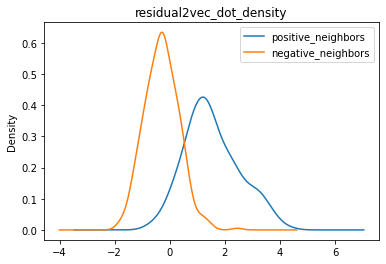

In [9]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [10]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 1368.72it/s]


((525, 2), 0.055319775577191234, 0.949825, 0.3791985607666264)

# deepwalk

In [11]:
model = "deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 400


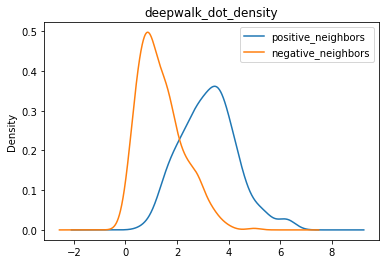

In [12]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [13]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 1907.72it/s]


((525, 2), 0.08039761682963342, 0.90905625, 0.46186537015723844)

# node2vec

In [14]:
model = "node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 400


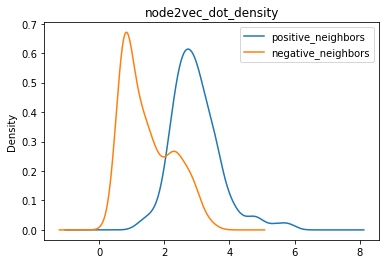

In [15]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [16]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 2409.69it/s]


((525, 2), 0.07121918892292708, 0.9123125, 0.4421029702317454)

# fairwalk+deepwalk

In [17]:
model = "fairwalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 400


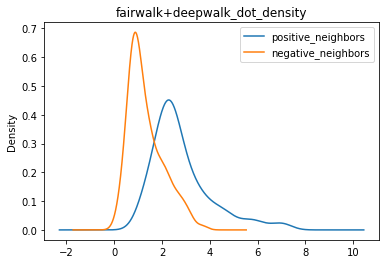

In [18]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [19]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 2059.26it/s]


((525, 2), 0.077854922582062, 0.8744562499999999, 0.4491688147188977)

# fairwalk+node2vec

In [20]:
model = "fairwalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(105, 128)

selected edge_idx size: 400


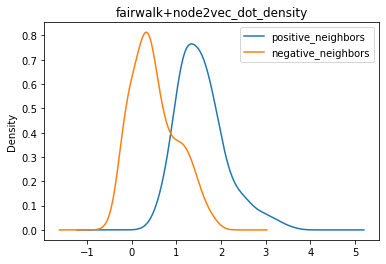

In [21]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [22]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 2617.51it/s]


((525, 2), 0.07400288891063746, 0.9173375, 0.4383634503828023)

# crosswalk+deepwalk

In [23]:
model = "crosswalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 400


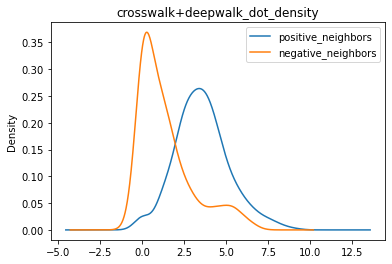

In [24]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [25]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 2347.65it/s]


((525, 2), 0.0878637014312718, 0.8408062500000001, 0.47297344586378115)

# crosswalk+node2vec

In [26]:
model = "crosswalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 400


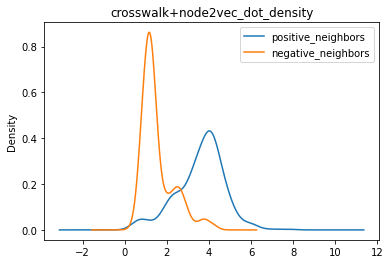

In [27]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [28]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 2571.30it/s]


((525, 2), 0.06522552059850367, 0.9132749999999998, 0.3986402160106062)

# GCN+deepwalk+random

In [29]:
model = "GCN+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 400


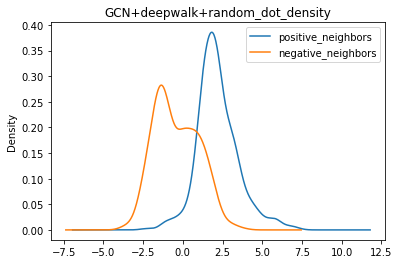

In [30]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [31]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 3297.93it/s]


((525, 2), 0.08478938459831657, 0.9162500000000001, 0.4774936401385941)

# GCN+deepwalk+r2v

In [32]:
model = "GCN+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(105, 128)

selected edge_idx size: 400


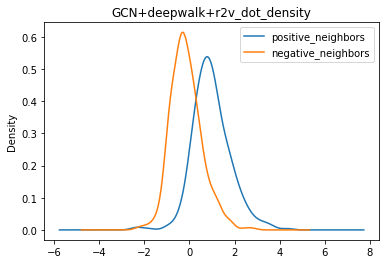

In [33]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [34]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 2657.65it/s]


((525, 2), 0.06829016422074707, 0.8649562500000001, 0.42547694350139253)

# GCN+node2vec+random

In [35]:
model = "GCN+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 400


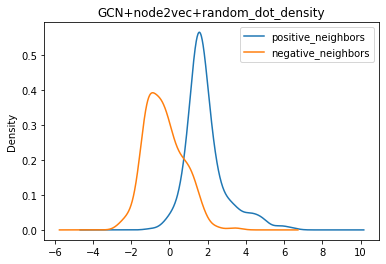

In [36]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [37]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 2614.25it/s]


((525, 2), 0.07850703979357815, 0.94216875, 0.4601239217845972)

# GCN+node2vec+r2v

In [38]:
model = "GCN+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 400


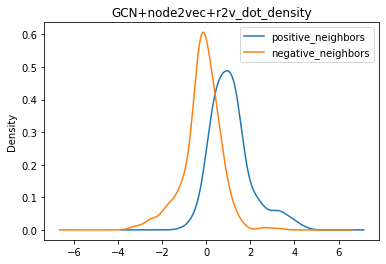

In [39]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [40]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 2833.61it/s]


((525, 2), 0.06995215306137985, 0.8760593750000001, 0.4336630099685451)

# GAT+deepwalk+random

In [41]:
model = "GAT+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 400


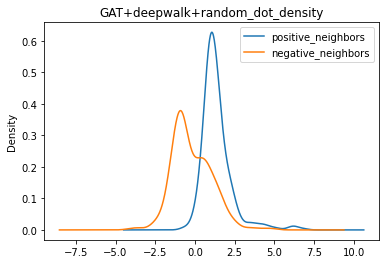

In [42]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [43]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 2863.40it/s]


((525, 2), 0.08015467769303537, 0.850225, 0.47074560564604334)

# GAT+deepwalk+r2v

In [44]:
model = "GAT+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 400


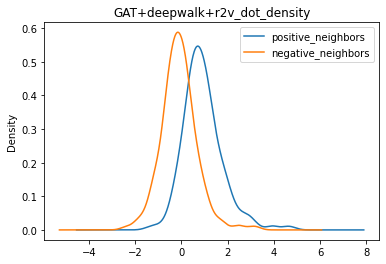

In [45]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [46]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 2868.49it/s]


((525, 2), 0.08093483072785798, 0.837703125, 0.45516233489523517)

# GAT+node2vec+random

In [47]:
model = "GAT+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 400


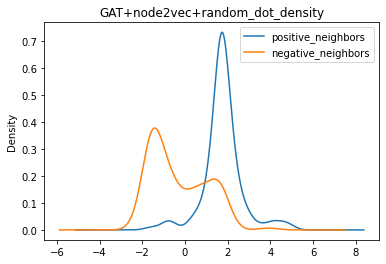

In [48]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [49]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 2349.75it/s]


((525, 2), 0.06484095284448714, 0.8979999999999999, 0.4079638054291856)

# GAT+node2vec+r2v

In [50]:
model = "GAT+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 400


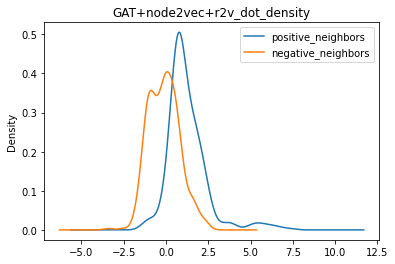

In [51]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [52]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 2127.36it/s]


((525, 2), 0.05600936979201122, 0.84790625, 0.3695509840181932)

# plot statistical parity scores

# gini sp scores

residual2vec 0.3791985607666264
deepwalk 0.46186537015723844
node2vec 0.4421029702317454
fairwalk+deepwalk 0.4491688147188977
fairwalk+node2vec 0.4383634503828023
crosswalk+deepwalk 0.47297344586378115
crosswalk+node2vec 0.3986402160106062
GCN+deepwalk+random 0.4774936401385941
GCN+deepwalk+r2v 0.42547694350139253
GCN+node2vec+random 0.4601239217845972
GCN+node2vec+r2v 0.4336630099685451
GAT+deepwalk+random 0.47074560564604334
GAT+deepwalk+r2v 0.45516233489523517
GAT+node2vec+random 0.4079638054291856
GAT+node2vec+r2v 0.3695509840181932


Text(0.5, 1.0, 'gini statistical parity scores')

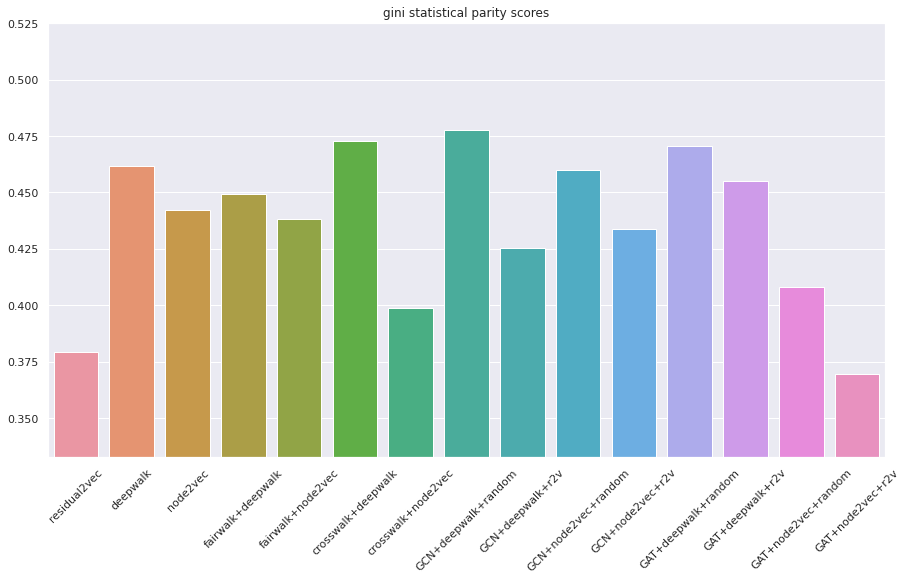

In [53]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9 , max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

residual2vec 0.055319775577191234
deepwalk 0.08039761682963342
node2vec 0.07121918892292708
fairwalk+deepwalk 0.077854922582062
fairwalk+node2vec 0.07400288891063746
crosswalk+deepwalk 0.0878637014312718
crosswalk+node2vec 0.06522552059850367
GCN+deepwalk+random 0.08478938459831657
GCN+deepwalk+r2v 0.06829016422074707
GCN+node2vec+random 0.07850703979357815
GCN+node2vec+r2v 0.06995215306137985
GAT+deepwalk+random 0.08015467769303537
GAT+deepwalk+r2v 0.08093483072785798
GAT+node2vec+random 0.06484095284448714
GAT+node2vec+r2v 0.05600936979201122


Text(0.5, 1.0, 'statistical parity scores')

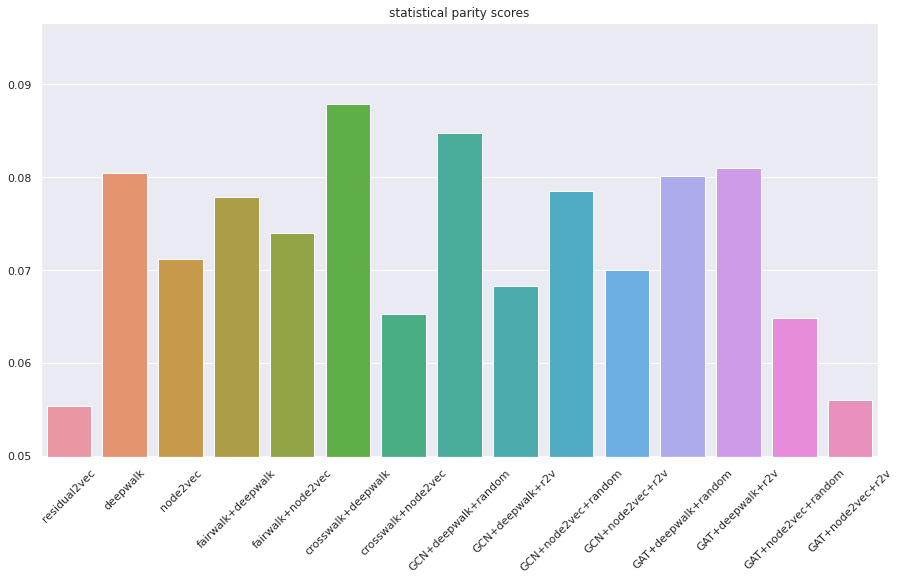

In [54]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

residual2vec 0.949825
deepwalk 0.90905625
node2vec 0.9123125
fairwalk+deepwalk 0.8744562499999999
fairwalk+node2vec 0.9173375
crosswalk+deepwalk 0.8408062500000001
crosswalk+node2vec 0.9132749999999998
GCN+deepwalk+random 0.9162500000000001
GCN+deepwalk+r2v 0.8649562500000001
GCN+node2vec+random 0.94216875
GCN+node2vec+r2v 0.8760593750000001
GAT+deepwalk+random 0.850225
GAT+deepwalk+r2v 0.837703125
GAT+node2vec+random 0.8979999999999999
GAT+node2vec+r2v 0.84790625


Text(0.5, 1.0, 'roc scores')

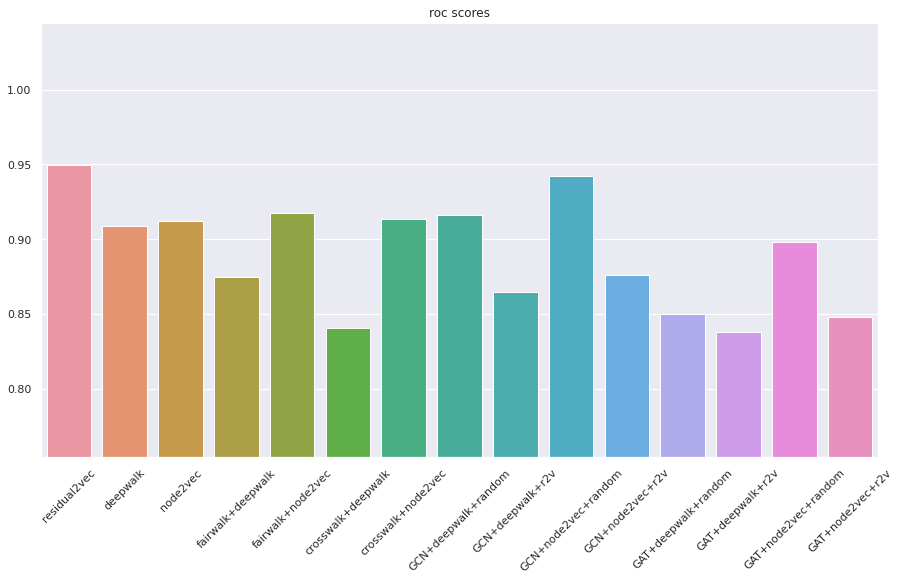

In [55]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [56]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        batch_size =  2000
        A = embs[m]
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, k, batch_size)
        
    
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 3033.20it/s]


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 3266.59it/s]


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 2501.08it/s]


Text(0.5, 1.0, 'gini scores vs # nn')

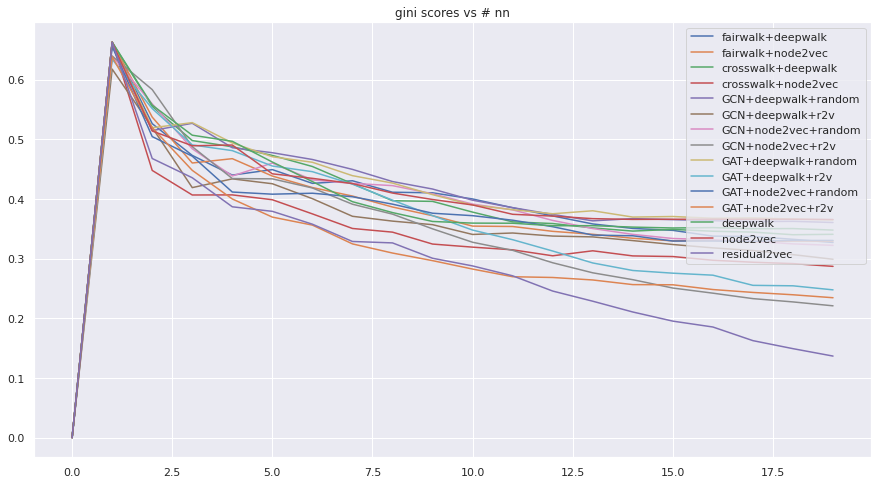

In [57]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

Text(0.5, 1.0, 'sp scores vs # nn')

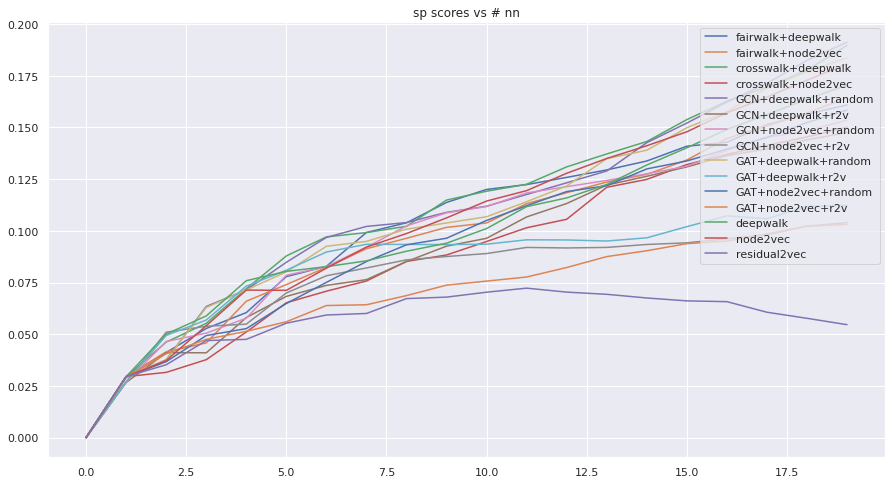

In [58]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [59]:

def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        file = DATA_ROOT + d + DATASET + '_test_adj.npz'
        dot = create_dot_df(A, file)
        scores[idx] = get_roc_score(dot)
    return scores


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, K, batch_size)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return scores, scores_gini

selected edge_idx size: 400
selected edge_idx size: 404
selected edge_idx size: 395
selected edge_idx size: 404
selected edge_idx size: 409
selected edge_idx size: 400
selected edge_idx size: 404
selected edge_idx size: 395
selected edge_idx size: 404
selected edge_idx size: 409
selected edge_idx size: 400
selected edge_idx size: 404
selected edge_idx size: 395
selected edge_idx size: 404
selected edge_idx size: 409
selected edge_idx size: 400
selected edge_idx size: 404
selected edge_idx size: 395
selected edge_idx size: 404
selected edge_idx size: 409
selected edge_idx size: 400
selected edge_idx size: 404
selected edge_idx size: 395
selected edge_idx size: 404
selected edge_idx size: 409
selected edge_idx size: 400
selected edge_idx size: 404
selected edge_idx size: 395
selected edge_idx size: 404
selected edge_idx size: 409
selected edge_idx size: 400
selected edge_idx size: 404
selected edge_idx size: 395
selected edge_idx size: 404
selected edge_idx size: 409
selected edge_idx si

Text(0.5, 1.0, 'roc scores')

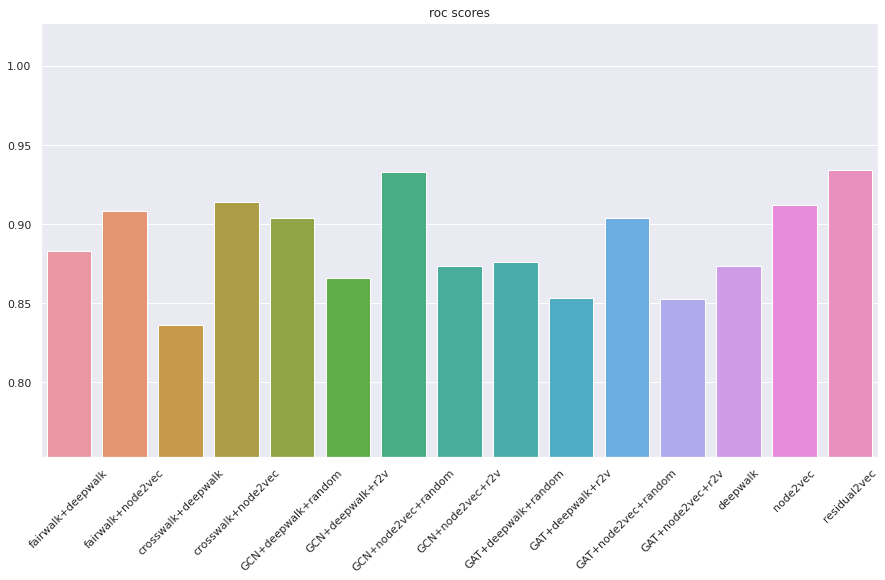

In [60]:

roc_score = {m: np.mean(roc_scores(m)) for m in model_to_embs}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 2793.22it/s]


fairwalk+deepwalk 0.06511584638436654
fairwalk+node2vec 0.06444493489745973
crosswalk+deepwalk 0.0646692293921822
crosswalk+node2vec 0.06294133033181548
GCN+deepwalk+random 0.0668901708789506
GCN+deepwalk+r2v 0.06884808619053602
GCN+node2vec+random 0.0737190083767397
GCN+node2vec+r2v 0.06768449246304434
GAT+deepwalk+random 0.06945878003314351
GAT+deepwalk+r2v 0.07115001247837832
GAT+node2vec+random 0.06783796676836393
GAT+node2vec+r2v 0.06314080852530066
deepwalk 0.06912792002211002
node2vec 0.07006017904529684
residual2vec 0.05349555484458842


Text(0.5, 1.0, 'statistical parity scores')

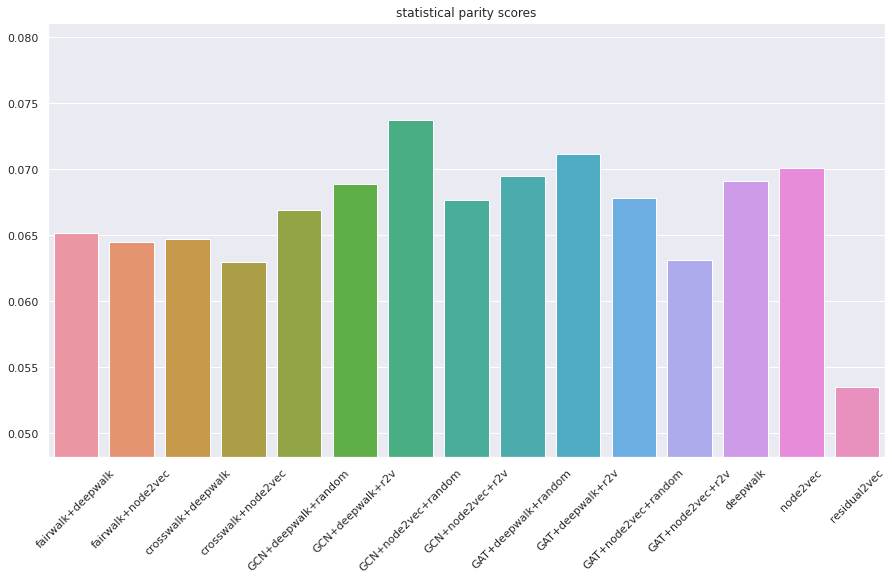

In [61]:

temp = {m: statisticalp_scores(m) for m in model_to_embs}

sp_score = {m: np.mean(v[0]) for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

fairwalk+deepwalk 0.40877294481425386
fairwalk+node2vec 0.4046660896816869
crosswalk+deepwalk 0.39639422932267926
crosswalk+node2vec 0.39404188659891126
GCN+deepwalk+random 0.41200075735513997
GCN+deepwalk+r2v 0.42907048467766257
GCN+node2vec+random 0.44274916996596064
GCN+node2vec+r2v 0.415661820324584
GAT+deepwalk+random 0.42445714492928593
GAT+deepwalk+r2v 0.4240870409190081
GAT+node2vec+random 0.4263248264739138
GAT+node2vec+r2v 0.40197759164791363
deepwalk 0.4181870678365872
node2vec 0.4367151195672127
residual2vec 0.36929068417711336


Text(0.5, 1.0, 'gini statistical parity scores')

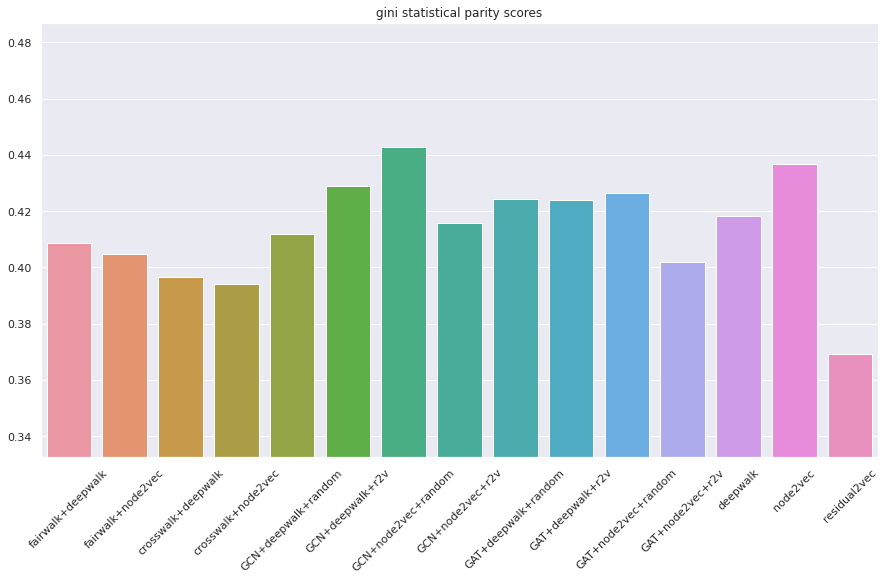

In [62]:
gini_score = {m: np.mean(v[1]) for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9, max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

In [63]:

# roc_score, sp_score, gini_score= {}, {}, {}
roc_score = {m: roc_scores(m) for m in model_to_embs}
temp = {m: statisticalp_scores(m) for m in model_to_embs}
sp_score = {m: v[0] for m,v in temp.items()}
gini_score = {m: v[1] for m,v in temp.items()}
pkl.dump(roc_score, open(DATA_ROOT + "roc_score.pkl", 'wb'))

pkl.dump(sp_score, open(DATA_ROOT + "sp_score.pkl", 'wb'))

pkl.dump(gini_score, open(DATA_ROOT + "gini_score.pkl", 'wb'))

selected edge_idx size: 400
selected edge_idx size: 404
selected edge_idx size: 395
selected edge_idx size: 404
selected edge_idx size: 409
selected edge_idx size: 400
selected edge_idx size: 404
selected edge_idx size: 395
selected edge_idx size: 404
selected edge_idx size: 409
selected edge_idx size: 400
selected edge_idx size: 404
selected edge_idx size: 395
selected edge_idx size: 404
selected edge_idx size: 409
selected edge_idx size: 400
selected edge_idx size: 404
selected edge_idx size: 395
selected edge_idx size: 404
selected edge_idx size: 409
selected edge_idx size: 400
selected edge_idx size: 404
selected edge_idx size: 395
selected edge_idx size: 404
selected edge_idx size: 409
selected edge_idx size: 400
selected edge_idx size: 404
selected edge_idx size: 395
selected edge_idx size: 404
selected edge_idx size: 409
selected edge_idx size: 400
selected edge_idx size: 404
selected edge_idx size: 395
selected edge_idx size: 404
selected edge_idx size: 409
selected edge_idx si

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 2973.42it/s]
